In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

# 1. Loading Data

In [3]:
df = pd.read_csv('fake_bills.csv', sep=';')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
df.shape

(1500, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


# Data Distribution

In [6]:
df.is_genuine.value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

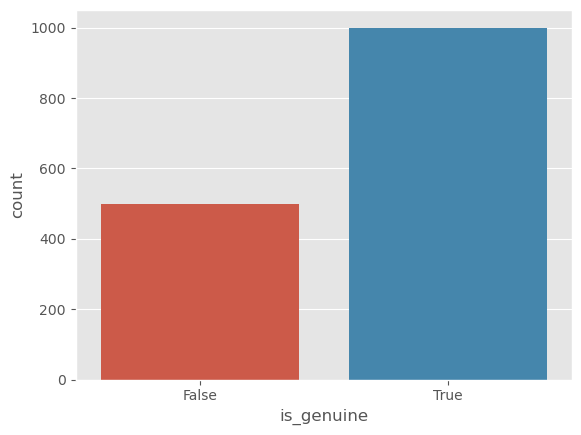

In [7]:
sns.countplot(data=df, x='is_genuine');

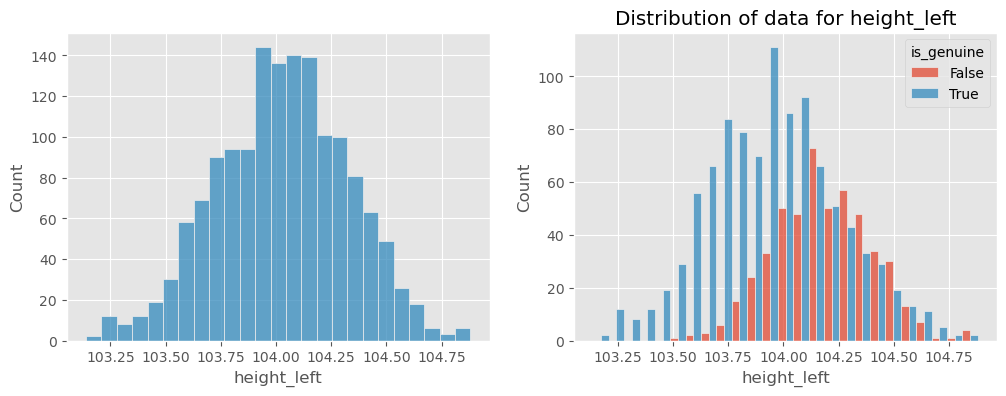

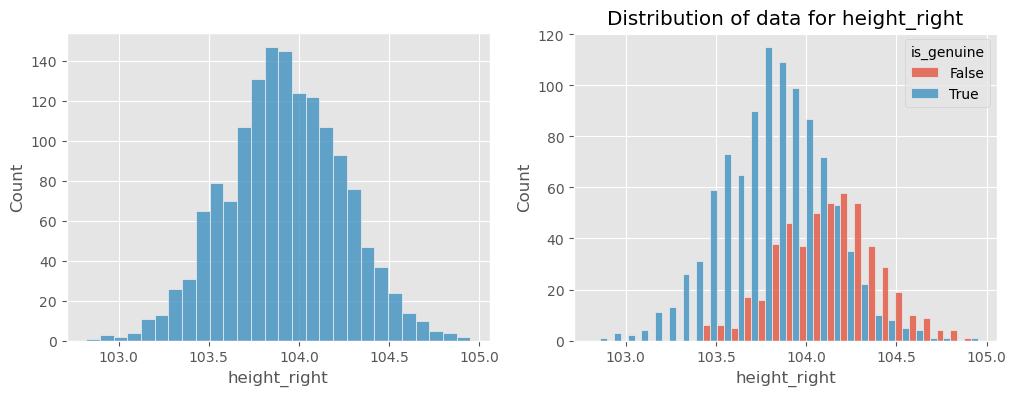

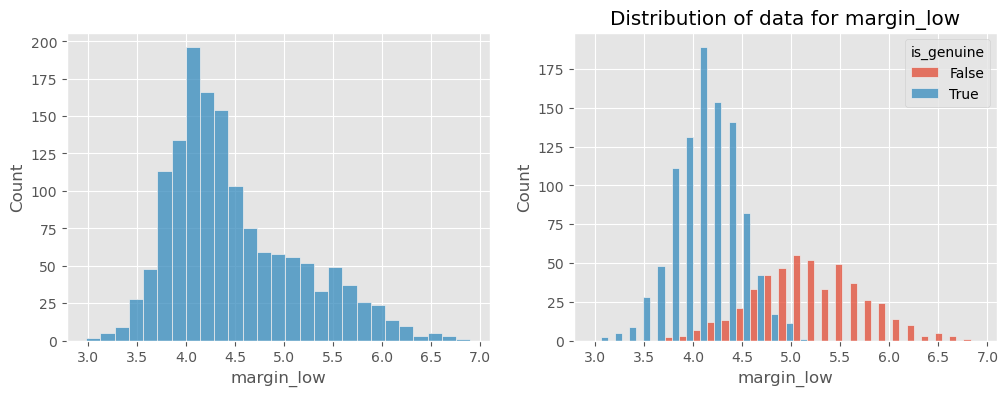

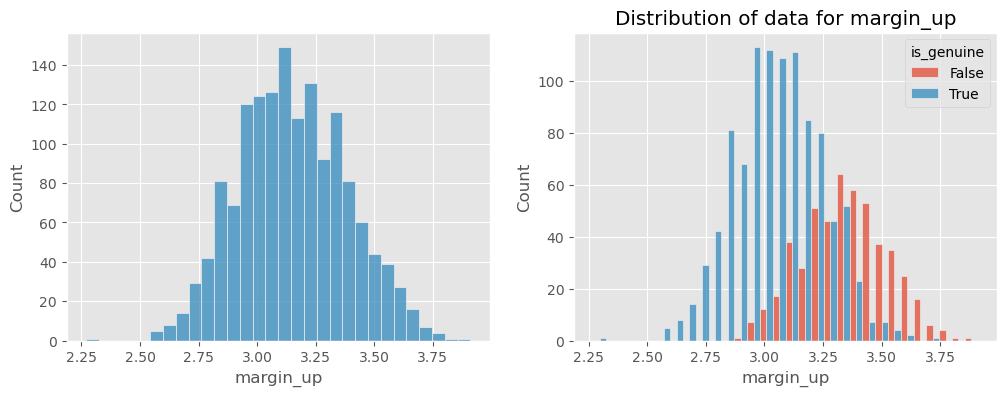

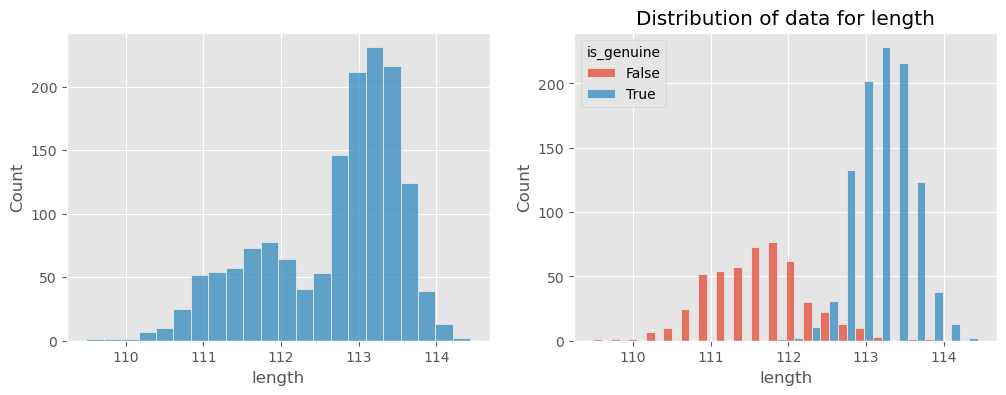

In [8]:
for col in df.columns[2:]:
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    sns.histplot(data=df, x=col, ax=ax[0])
    sns.histplot(data=df, x=col, hue='is_genuine', ax=ax[1], multiple='dodge')
    plt.title(f"Distribution of data for {col}")
    plt.show()

# Correlation Between the Variables

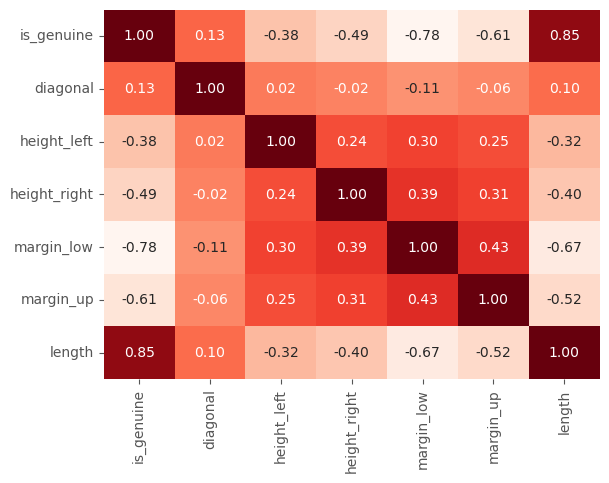

In [9]:
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cbar=None, cmap='Reds');


In [10]:
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split


from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import mean_absolute_percentage_error, r2_score, accuracy_score, confusion_matrix, classification_report


# 2. Missing Values & Separating Train and Test Splits

In [11]:
train = df[df['margin_low'].notna()].copy()
test = df[df['margin_low'].isna()].copy()


y_train = train['margin_low']
X_train = train.drop(['margin_low', 'is_genuine'], axis=1)

#y_test = test['margin_low']
X_test = test.drop(['margin_low', 'is_genuine'], axis=1)

#  Model Evaluation

In [12]:
model = LinearRegression()

y_pred_val = cross_val_predict(model, X_train, y_train, cv=10, n_jobs=-1)

mape_val = mean_absolute_percentage_error(y_train, y_pred_val)
r2_val = r2_score(y_train, y_pred_val)

print(f'The mean absolute error for the validation data is: {mape_val:.3f}')
print(f'The r2 for the validation data is: {r2_val:.3f}')

The mean absolute error for the validation data is: 0.083
The r2 for the validation data is: 0.463


# Visualizing Predictions

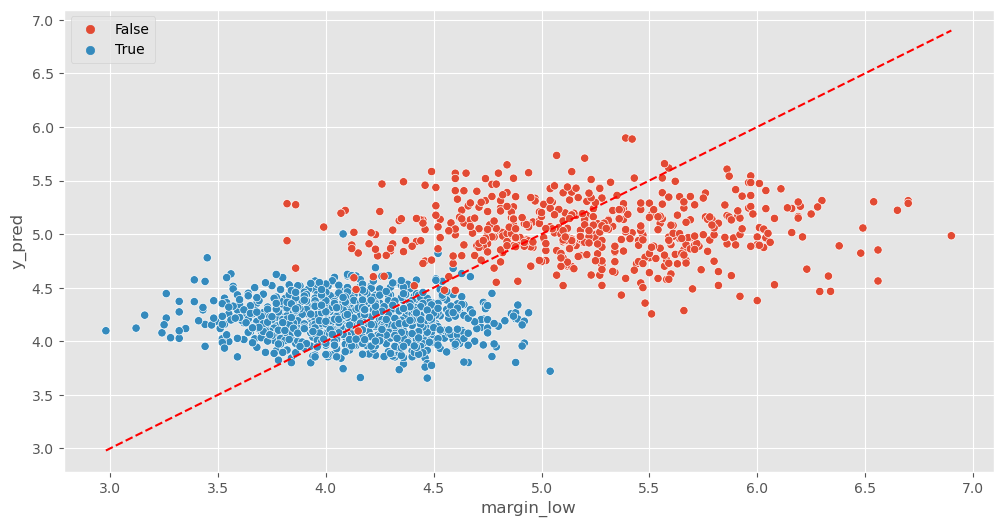

In [13]:
min_y_train = np.min(y_train)
min_y_pred = np.min(y_pred_val)

max_y_train = np.max(y_train)
max_y_pred = np.max(y_pred_val)

min_xy = min(min_y_train, min_y_pred)
max_xy = max(max_y_train, max_y_pred)

results=train.copy()
results['y_pred'] = y_pred_val 

plt.figure(figsize=(12,6))
sns.scatterplot(data=results, x='margin_low', y='y_pred', hue='is_genuine')
sns.lineplot(x=[min_xy, max_xy], y=[min_xy, max_xy], linestyle='--', color='red');

# Final Model and Prediction of Missing Values

In [14]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

test['margin_low'] = y_pred

In [15]:
df = pd.concat([train, test])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


# Creating New Columns
As long as we had missing values, we couldn't create columns based on margin_low so we can create a few columns with a clearer distinction between genuine and fake bills

In [17]:
df['margin_total'] = df['margin_up'] + df['margin_low']
df['margin_diff'] = df['margin_up'] - df['margin_low']

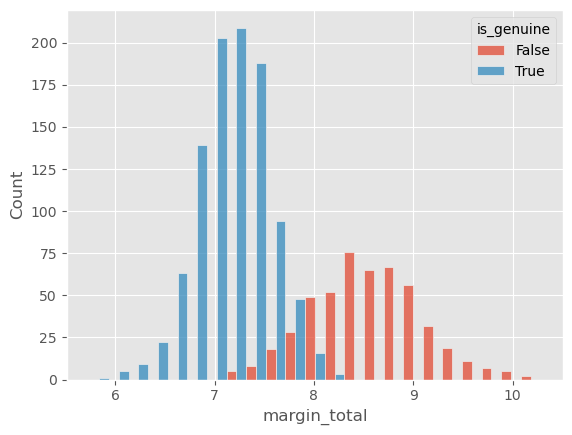

In [18]:
sns.histplot(data=df, x='margin_total', hue='is_genuine', multiple='dodge');

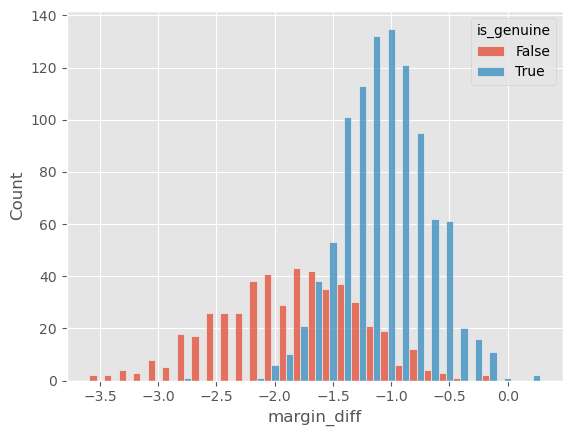

In [19]:
sns.histplot(data=df, x='margin_diff', hue='is_genuine', multiple='dodge');

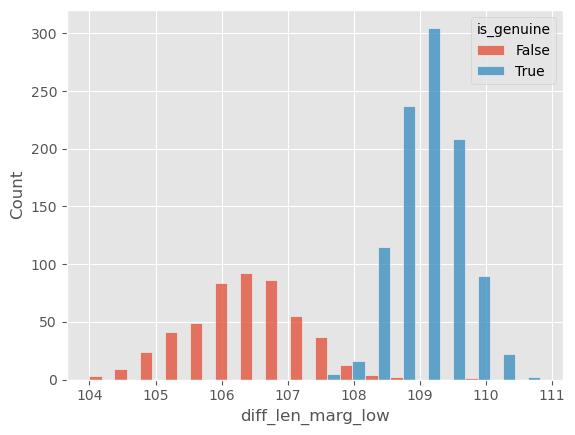

In [20]:
df['diff_len_marg_low'] = df['length'] - df['margin_low']

sns.histplot(data=df, x='diff_len_marg_low', hue='is_genuine', multiple='dodge');

# 3.Modeling Without Data Transform

In [22]:
y = df['is_genuine']
X = df.drop('is_genuine', axis=1)

# Logistic Regression

In [23]:
model = LogisticRegression()

y_pred = cross_val_predict(model, X, y, cv=10, n_jobs=-1)

acc = accuracy_score(y, y_pred)

print(f'The accuracy score for Logistic Regression is: {acc:.3f}')

The accuracy score for Logistic Regression is: 0.990


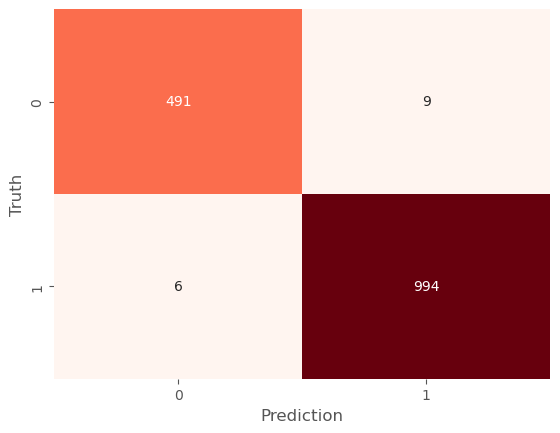

In [24]:
conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, annot=True, cbar=None, cmap='Reds', fmt='.0f')
plt.ylabel('Truth')
plt.xlabel('Prediction');

In [25]:
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       500
        True       0.99      0.99      0.99      1000

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



# K Neighbors Classifier

In [26]:
from sklearn.model_selection import cross_val_score

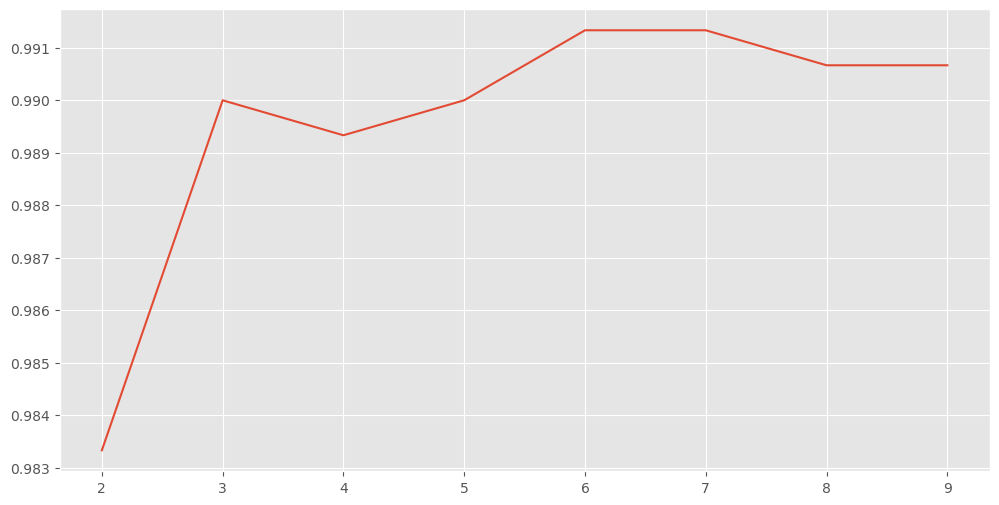

In [27]:
neighbors = [2,3,4,5,6,7,8,9]
scores = []


for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    acc = cross_val_score(model, X, y, cv=10, n_jobs=-1)
    
    scores.append(np.mean(acc))
    
plt.figure(figsize=(12,6))
sns.lineplot(x=neighbors, y=scores);

In [28]:
model = KNeighborsClassifier(n_neighbors=7)

y_pred = cross_val_predict(model, X, y, cv=10, n_jobs=-1)

acc = accuracy_score(y, y_pred)

print(f'The accuracy score for K-Neighbors Classifier is: {acc:.3f}')

The accuracy score for K-Neighbors Classifier is: 0.991


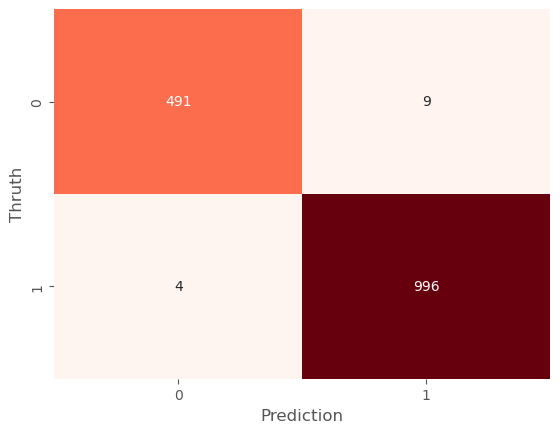

In [29]:
conf_mat = confusion_matrix(y, y_pred)

sns.heatmap(conf_mat, annot=True, cmap='Reds', cbar=None, fmt='.0f')
plt.ylabel('Thruth')
plt.xlabel('Prediction');

In [30]:
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       500
        True       0.99      1.00      0.99      1000

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



# K-Means

In [31]:
X.drop(['margin_diff', 'margin_total', 'diff_len_marg_low'], axis=1, inplace=True)

In [32]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

results = X.copy()
results['labels'] = kmeans.labels_
results['truth'] = y

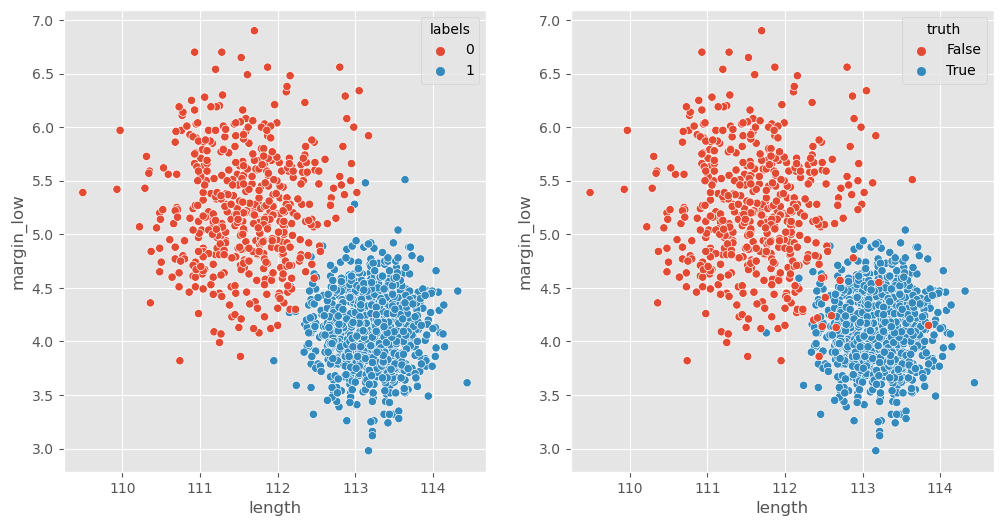

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(data=results, x='length', y='margin_low', hue='labels', ax=ax[0])
sns.scatterplot(data=results, x='length', y='margin_low', hue='truth', ax=ax[1]);

 The two plots look quite similar despite a slight imperfection in the decision boundaries. Our K-Means seem to have done a good job at splitting the real and fake bills in two groups

In [34]:
dic_label = {True: 1, False: 0}
results['truth'] = results['truth'].map(dic_label)

acc = accuracy_score(results['truth'], results['labels'])

print(f'The accuracy score for K-Means Clustering is : {acc:.3f}')

The accuracy score for K-Means Clustering is : 0.985


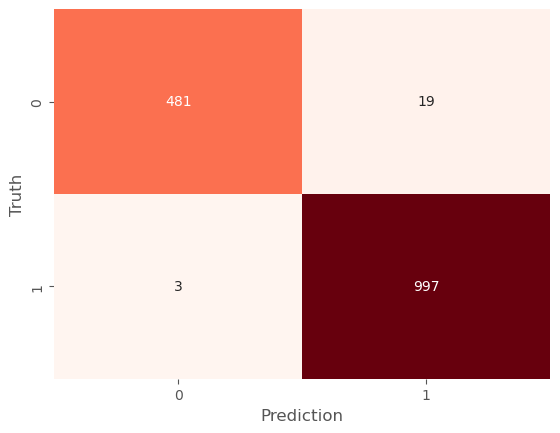

In [35]:
conf_mat = confusion_matrix(results['truth'], results['labels'])

sns.heatmap(conf_mat, annot=True, cmap='Reds', cbar=None, fmt='.0f')
plt.ylabel('Truth')
plt.xlabel('Prediction');

In [36]:
report = classification_report(results['truth'], results['labels'])

print(report)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       500
           1       0.98      1.00      0.99      1000

    accuracy                           0.99      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.99      0.99      0.99      1500



# 4. Summary
Using Logistic Regression and KNN we achieve a 99% accuracy,

The K-Means did nearly as well with an accuracy of 98.5%
To choose the best model, we need to decide if it is better to let a few fake bills beeing unnoticed or if it is better to have real bills labelled as fake bills.